In [1]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from circuit_partition import *

In [2]:
d = 4
k = 3
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
measure_qubits_ord_kxk = get_measure_qubits_ord(k)
data_qubits_ord_dxd = get_data_qubits_ord(d)
data_qubits_ord_kxk = get_data_qubits_ord(k)

In [3]:
# Plot the dxd array

def plot_qubits(data, measure, d, kernels = [], point_size = 400):
  arr_data = []
  arr_measure_Z = []
  arr_measure_X = []

  for q in data:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    arr_data.append([x, y])
  for q in measure:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    lbl = q[1]
    if lbl=="M:Z":
      arr_measure_Z.append([x, y])
    else:
      arr_measure_X.append([x, y])

  arr_data = np.array(arr_data)
  arr_measure_Z = np.array(arr_measure_Z)
  arr_measure_X = np.array(arr_measure_X)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(arr_data[:,0], arr_data[:,1], label='Data qubits', s=point_size, marker='o', facecolors='none', edgecolors='black')
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='gray', edgecolors='black', alpha=0.5)
  ax.scatter(arr_measure_Z[:,0], arr_measure_Z[:,1], label='Measure Z', s=point_size, marker='o', facecolors='orange', edgecolors='orange', alpha=0.5)
  ax.scatter(arr_measure_X[:,0], arr_measure_X[:,1], label='Measure X', s=point_size, marker='o', facecolors='blue', edgecolors='blue', alpha=0.5)
  for iq in range(arr_measure_Z.shape[0]):
    ax.text(arr_measure_Z[iq, 0], arr_measure_Z[iq, 1], 'Z', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_measure_X.shape[0]):
    ax.text(arr_measure_X[iq, 0], arr_measure_X[iq, 1], 'X', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_data.shape[0]):
    ax.text(arr_data[iq, 0], arr_data[iq, 1], 'D', fontsize=12, color='black', ha='center', va='center')

  # Draw an envelope that encloses kernel_data nad kernel_measure qubits, which are a subset of data and measure qubits already drawn
  for kernel in kernels:
    kernel_data = kernel[0]
    kernel_measure = kernel[1]
    kernel_color = kernel[2]
    arr_kernel = []
    for q in kernel_data:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    for q in kernel_measure:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    arr_kernel = np.array(arr_kernel)
    # Make a set of lines that enclose the outer edges of the kernel data or measure qubits
    for iq in range(arr_kernel.shape[0]):
      for iedge in range(4):
        if iedge==0: # Top edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]>arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]+0.5+offset, arr_kernel[iq][1]+0.5+offset], color=kernel_color, linestyle='--', linewidth=4, alpha=0.45)
        elif iedge==1: # Bottom edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==-1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]<arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]-0.5-offset, arr_kernel[iq][1]-0.5-offset], color=kernel_color, linestyle='--', linewidth=4, alpha=0.45)
        elif iedge==2: # Left edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==-1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]<arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5-offset, arr_kernel[iq][0]-0.5-offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=0.45)
        elif iedge==3: # Right edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]>arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]+0.5+offset, arr_kernel[iq][0]+0.5+offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=0.45)

  # Remove axis labels
  ax.set_xticks([])
  ax.set_yticks([])
  #ax.legend()
  fig.set_dpi(120)
  plt.show()

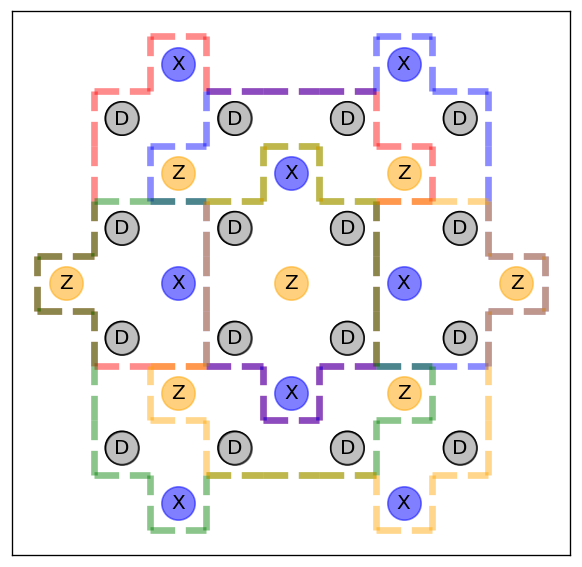

In [4]:
shifted_data_kxk_TL, shifted_measure_kxk_TL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
shifted_data_kxk_TR, shifted_measure_kxk_TR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 0)
shifted_data_kxk_BL, shifted_measure_kxk_BL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 1)
shifted_data_kxk_BR, shifted_measure_kxk_BR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)


plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, 
  [
    [shifted_data_kxk_TL, shifted_measure_kxk_TL, 'red'],
    [shifted_data_kxk_TR, shifted_measure_kxk_TR, 'blue'],
    [shifted_data_kxk_BL, shifted_measure_kxk_BL, 'green'],
    [shifted_data_kxk_BR, shifted_measure_kxk_BR, 'orange']
  ]
)

In [5]:
d = 9
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

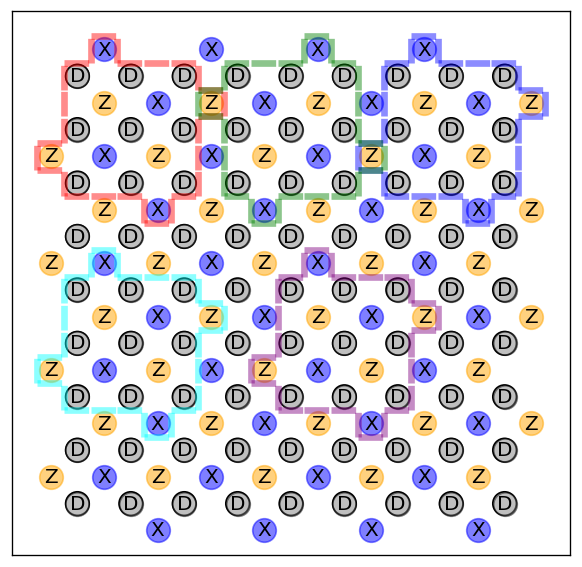

In [6]:
kernels5=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
kernels5.append([shifted_data_kxk, shifted_measure_kxk, 'red'])

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 6, 0)
kernels5.append([shifted_data_kxk, shifted_measure_kxk, 'blue'])

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 0)
kernels5.append([shifted_data_kxk, shifted_measure_kxk, 'green'])

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 4)
kernels5.append([shifted_data_kxk, shifted_measure_kxk, 'cyan'])

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 4, 4)
kernels5.append([shifted_data_kxk, shifted_measure_kxk, 'purple'])

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels5, point_size = 200
)